In [162]:
from discretize import TensorMesh, TreeMesh
from SimPEG import utils
import matplotlib.pyplot as plt
import numpy as np
import discretize
def create_local_mesh(
    src_location,
    rx_location,
    topo_location,
    topo,
    h = [10., 10., 5.],
    x_core_lim = (-100., 100.),
    y_core_lim = (-20., 20.),
    ):

    # TODO: All parameters used for generating this mesh should be input parameters
    # Currently fixed for a specific case

    xyz = np.vstack((rx_location, src_location))
    x = np.linspace(x_core_lim[0], x_core_lim[1]) + src_location[0]
    y = np.linspace(y_core_lim[0], y_core_lim[1]) + src_location[1]
    dem = utils.ndgrid(x, y, np.r_[topo_location[2]])

    mesh_local = discretize.utils.mesh_builder_xyz(
        dem,
        h,
        padding_distance=[[2000., 2000.], [2000., 2000.], [2000., 2000.]],
        base_mesh=None,
        depth_core=None,
        expansion_factor=1.3,
        mesh_type='tree'
    )

    mesh_local = discretize.utils.refine_tree_xyz(
        mesh_local,
        dem,
        method='surface',
        octree_levels=[5, 10, 10],
        octree_levels_padding=None,
        finalize=False,
        min_level=0,
        max_distance=np.inf,
    )


    mesh_local = discretize.utils.refine_tree_xyz(
        mesh_local,
        xyz,
        method='radial',
        octree_levels=[2, 0, 0],
        octree_levels_padding=None,
        finalize=True,
        min_level=1,
        max_distance=np.inf,
    )

    actv_local = utils.surface2ind_topo(mesh_local, topo)

    return mesh_local, actv_local

In [164]:
src_location = np.array([0, 0, 30])
rx_location = np.array([0, 0, 30])
topo_location = np.array([0, 0, 0])
x = np.linspace(-50, 50)
y = np.linspace(-50, 50)
z = np.array([0.])
topo = utils.ndgrid(x,y,z)
mesh_tree, ind_active_tree = create_local_mesh(src_location, rx_location, topo_location, topo)

In [194]:
dx = 100
dy = 100
dz = 5
hx = np.ones(100) * dx
hy = np.ones(100) * dx
hz = np.ones(60) * dz
mesh =TensorMesh([hx, hy, hz], x0=[-hx.sum()/2, -hy.sum()/2, -hz.sum() + 30.])
ind_active = mesh.gridCC[:,2]<0.
sigma = np.ones(mesh.n_cells) * 1./1e8
sigma[ind_active] = 1./100.

In [195]:
Pmesh = discretize.utils.volume_average(mesh, mesh_tree)

(<matplotlib.collections.QuadMesh at 0x15c09415a30>,)

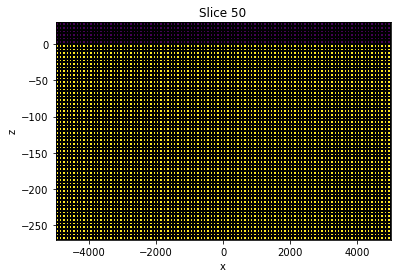

In [196]:
mesh.plot_slice(sigma, grid=True, normal='Y', pcolor_opts={'norm':LogNorm()})

In [197]:
import scipy.sparse as sp

In [198]:
n = ind_active_tree.sum()
m = ind_active_tree.size
J = np.argwhere(ind_active_tree).flatten()
I = np.arange(n)
data = np.ones(n)
Pactive = sp.coo_matrix((data,(I, J)), shape=(n,m))

In [199]:
test = Pmesh @ (sigma)

In [200]:
from matplotlib.colors import LogNorm

(<matplotlib.collections.PolyCollection at 0x15c09a9aa60>,)

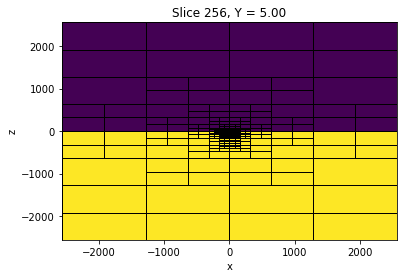

In [201]:
mesh_tree.plot_slice((test), grid=True, normal='Y', pcolor_opts={'norm':LogNorm()})
# plt.xlim(-100, 100)
# plt.ylim(-100, 100)

In [202]:
from SimPEG import maps

In [205]:
import numpy as np
import scipy.sparse as sp
import numpy as np
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

from SimPEG.electromagnetics.time_domain import Simulation3DElectricField


class SimulationAEM(Simulation3DElectricField):
    """docstring for SimulationAEM"""

    def simulate(
        self,
        m,
        time_ch1,
        time_input_currents_ch1,
        input_currents_ch1,
        time_ch2=None,
        time_input_currents_ch2=None,
        input_currents_ch2=None,
        eps=1e-10,
    ):
        if self.verbose:
            print('{}\nSimulating SkyTEM data\n{}'.format('*'*50, '*'*50))

        self.model = m
        n_steps = self.timeSteps.size
        factor = 3/2.
        nSrc = self.survey.nSrc
        data_stepoff = np.zeros(
            (self.timeSteps.size, nSrc), dtype=float, order='C'
        )

        sol_n0 = np.zeros((self.mesh.nE, nSrc), dtype=float, order='F')
        sol_n1 = np.zeros((self.mesh.nE, nSrc), dtype=float, order='F')
        sol_n2 = np.zeros((self.mesh.nE, nSrc), dtype=float, order='F')
        s_e = np.zeros((self.mesh.nE, nSrc), order='F')

        locs = np.zeros((nSrc, 3), order='F')

        # Generate initial conditions
        C = self.mesh.edgeCurl
        for i_src, src in enumerate(self.survey.srcList):
            b0 = src.bInitial(self)
            s_e[:, i_src] = C.T*self.MfMui*b0
            locs[i_src, :] = src.rxList[0].locs

        # Assume only z-component
        # TODO: need to be generalized
        Fz = self.mesh.getInterpolationMat(locs, locType='Fz')

        #  Time steps
        dt_0 = 0.
        for ii in range(n_steps):
            dt = self.timeSteps[ii]
            # Factor for BDF2
            if abs(dt_0-dt) > eps:
                if ii != 0:
                    Ainv.clean()
                A = self.getAdiag(dt, factor=factor)
                if self.verbose:
                    print('Factoring...   (dt = {:e})'.format(dt))
                Ainv = self.Solver(A, **self.solverOpts)
                if self.verbose:
                    print('Done')

            # Need to integrate in to RHS and getAsubdiag
            if ii == 0:
                rhs = factor/dt*s_e
            elif ii == 1:
                rhs = -factor/dt*(
                    self.MeSigma*(-4/3.*sol_n1+1/3.*sol_n0) + 1./3.*s_e
                )
            else:
                rhs = -factor/dt*(
                    self.MeSigma*(-4/3.*sol_n1+1/3.*sol_n0)
                )
            if self.verbose:
                print('    Solving...   (tInd = {:d})'.format(ii+1))

            sol_n2 = Ainv*rhs

            if self.verbose:
                print('    Done...')

            # Need data matrix
            if nSrc > 1:
                data_stepoff[ii, :] = (Fz*(-C*sol_n2)).diagonal()
            else:
                sol_n2 = sol_n2.reshape([-1, 1])
                data_stepoff[ii] = (Fz*(-C*sol_n2))
            dt_0 = dt
            sol_n0 = sol_n1.copy()
            sol_n1 = sol_n2.copy()

        # clean factors and return
        Ainv.clean()
        data = np.zeros((nSrc, time.size), float, 'C')
        data_dual_moment = np.zeros((nSrc, time_dual_moment.size), float, 'C')

        for ii in range(nSrc):
            step_func = interp1d(
                np.log10(self.timeMesh.gridCC), data_stepoff[:, ii]
            )

            data_temp = piecewise_pulse_fast(
                                step_func, time,
                                time_input_currents, input_currents,
                                period, n_pulse=1
            )
            data_dual_moment_temp = piecewise_pulse_fast(
                                step_func, time_dual_moment,
                                time_input_currents_dual_moment, input_currents_dual_moment,
                                period_dual_moment, n_pulse=1
            )
            data[ii, :] = data_temp
            data_dual_moment[ii, :] = data_dual_moment_temp

        return np.r_[data.flatten(), data_dual_moment.flatten()]

    def getAdiag(self, dt, factor=1.):
        """
        Diagonal of the system matrix at a given time index
        """
        C = self.mesh.edgeCurl
        MfMui = self.MfMui
        MeSigma = self.MeSigma

        return C.T * (MfMui * C) + factor/dt * MeSigma

In [175]:
np.unique(test)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01])